In [1]:
import os

BASE_DIR = os.getcwd()
DATASET_ZIP_PATH = os.path.join(BASE_DIR, "asl-alphabet.zip")
EXTRACT_DIR = os.path.join(BASE_DIR, "asl-alphabet")

# Download
!curl -L -o {DATASET_ZIP_PATH} https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet

# Ekstra
os.makedirs(EXTRACT_DIR, exist_ok=True)
!unzip -q {DATASET_ZIP_PATH} -d {EXTRACT_DIR}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1049M  100 1049M    0     0  71.5M      0  0:00:14  0:00:14 --:--:-- 56.2M


In [2]:
import os
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
# Path to your dataset directory
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'asl-alphabet', 'asl_alphabet_train', 'asl_alphabet_train')
SEED = 42
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

all_image_paths = glob.glob(os.path.join(DATA_DIR, '*/*.jpg'))
all_labels = [os.path.basename(os.path.dirname(path)) for path in all_image_paths]
label_to_index = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
all_labels_idx = [label_to_index[label] for label in all_labels]

# Split pertama: Train (70%) dan Temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths,
    all_labels_idx,
    test_size=0.3,
    stratify=all_labels_idx,
    random_state=SEED
)

# Split kedua: Val (20%) dan Test (10%) dari Temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=1/3,  # 10% dari total (1/3 dari 30%)
    stratify=temp_labels,
    random_state=SEED
)

In [4]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

def build_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = build_dataset(train_paths, train_labels)
val_ds   = build_dataset(val_paths, val_labels)
test_ds  = build_dataset(test_paths, test_labels)

In [5]:
print("Jumlah gambar di Train  :", len(train_paths))
print("Jumlah gambar di Val    :", len(val_paths))
print("Jumlah gambar di Test   :", len(test_paths))

Jumlah gambar di Train  : 60900
Jumlah gambar di Val    : 17400
Jumlah gambar di Test   : 8700


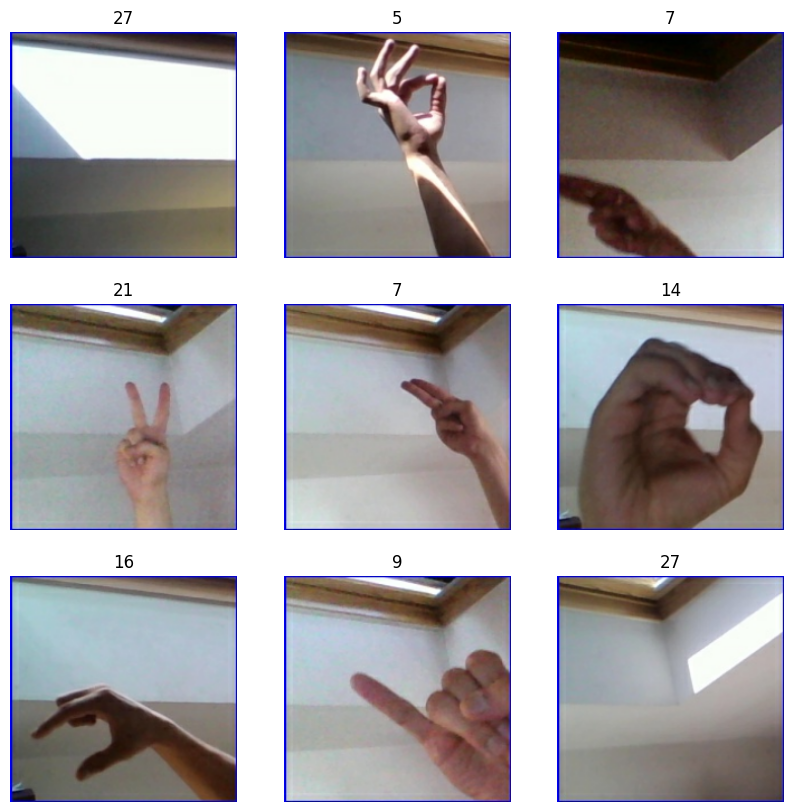

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
def create_model(input_shape=(224, 224, 3), num_classes=29):
    # Definisikan arsitektur utama model
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),  # Normalisasi

        # Base model/feature extractor
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Classifier head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [8]:
model = create_model()
model.compile(
    optimizer=optimizers.AdamW(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.8066 - sparse_categorical_accuracy: 0.2260
Epoch 1: val_loss improved from inf to 0.60328, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 177s 641ms/step - loss: 2.8031 - sparse_categorical_accuracy: 0.2267 - val_loss: 0.6033 - val_sparse_categorical_accuracy: 0.8228
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.7329 - sparse_categorical_accuracy: 0.7524
Epoch 2: val_loss improved from 0.60328 to 0.22249, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 107s 447ms/step - loss: 0.7324 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.2225 - val_sparse_categorical_accuracy: 0.9460
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.3673 - sparse_categorical_accuracy: 0.8729
Epoch 3: val_loss improved from 0.22249 to 0.09965, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 148s 474ms/step - loss: 0.3672 - sparse_categorical_accuracy: 0.8729 - val_loss: 

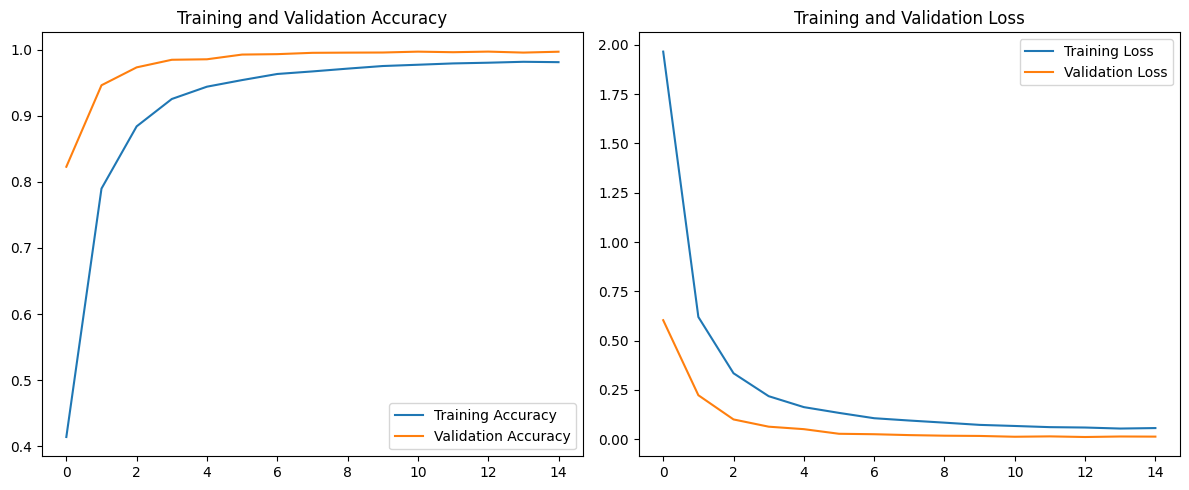

In [10]:
def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_history(history)

In [11]:
# Setelah training selesai, dan kamu load model terbaik dari .keras
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Simpan ke format SavedModel
model.export('saved_model/')  # ini valid di luar callback

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 511ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9956
Test Loss: 0.014196422882378101
Test Accuracy: 0.9957471489906311
Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  137639206011344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206012688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206014608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639791647184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639476345360: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [12]:
# Converter ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file .tflite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpl2zioz9l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  137639206011344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206012688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206013072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639206014608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639791647184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639476345360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639476345744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639476344784: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [13]:
!pip install tensorflowjs -q
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 102.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 

In [14]:
!zip -r model.zip /content/tfjs_model

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard43of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard5of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard40of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard25of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard32of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard41of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard21of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard47of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard38of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard34of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard31of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard28of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard19of50.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard2of50.bin (deflated 7%)
  adding: content/tfjs_model/model.j